In [1]:
from lab_01_utils import *
import sys 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from skimage.color import rgb2hsv
import cv2

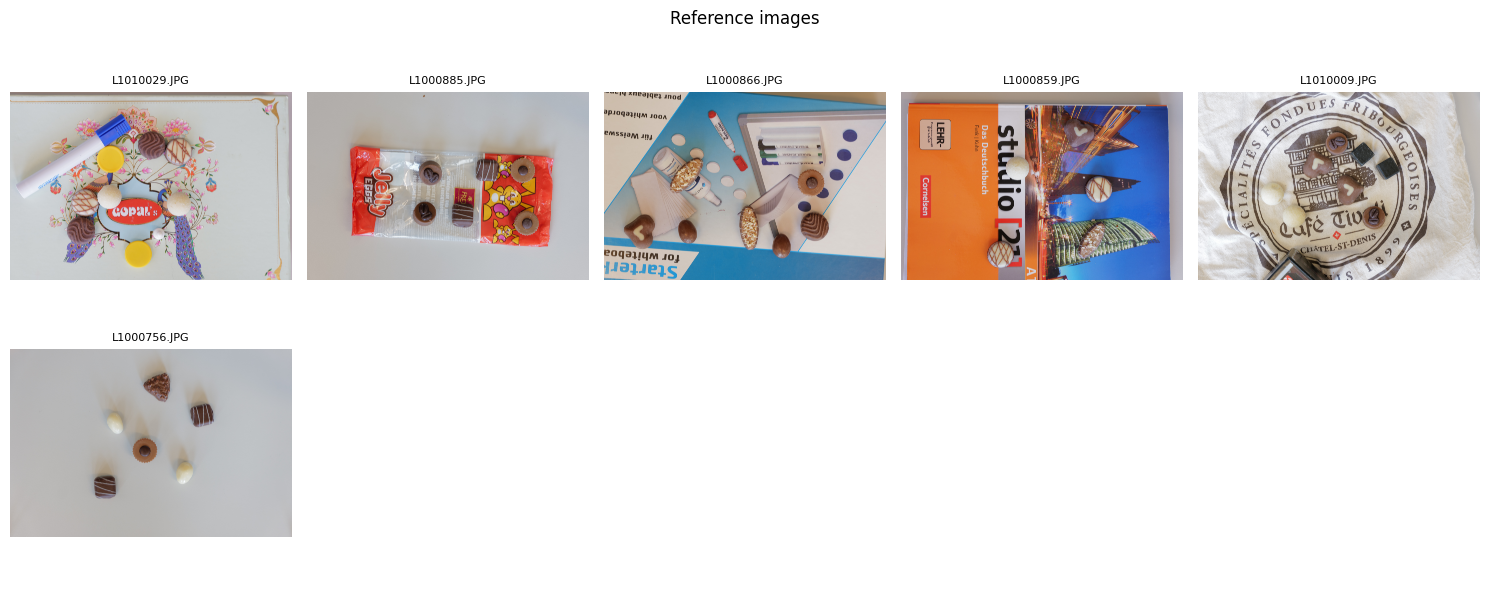

In [2]:
path_ref = '/Users/louiscuendet/Documents/EPFL NEURO-X /Image Analysis and Pattern Recognition/dataset_project_iapr2025/different_backgrounds'


jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

# Define grid size (square-ish)
cols = 5
rows = (n_images + cols - 1) // cols  # Round up division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

plt.suptitle('Reference images')

# Prepare list to store loaded images
loaded_images = []

for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        loaded_images.append(img)
        ax.imshow(img)
        ax.set_title(jpg_files[i], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

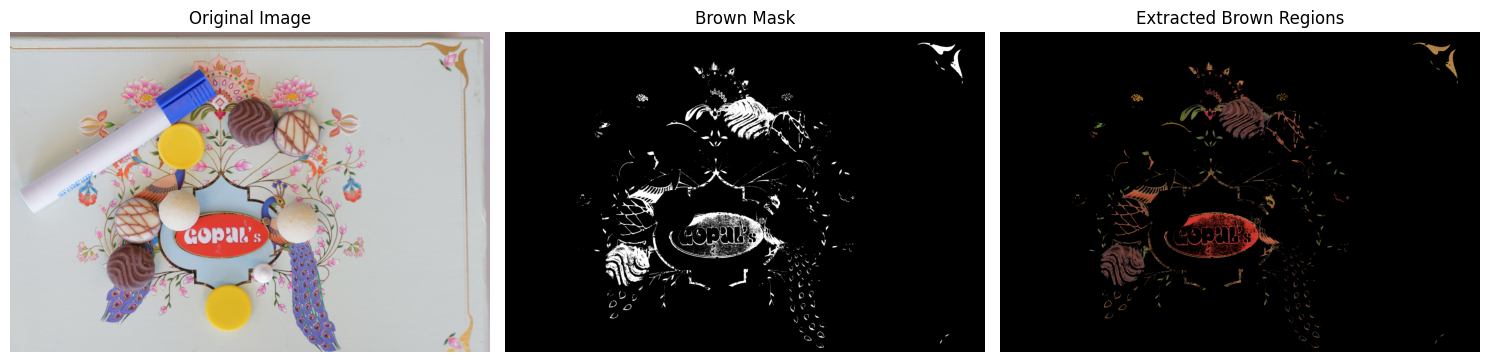

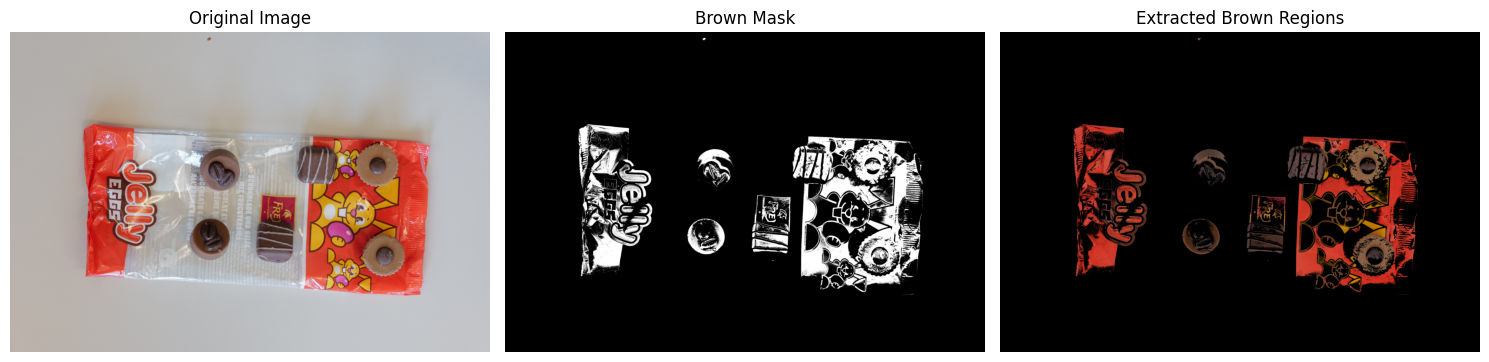

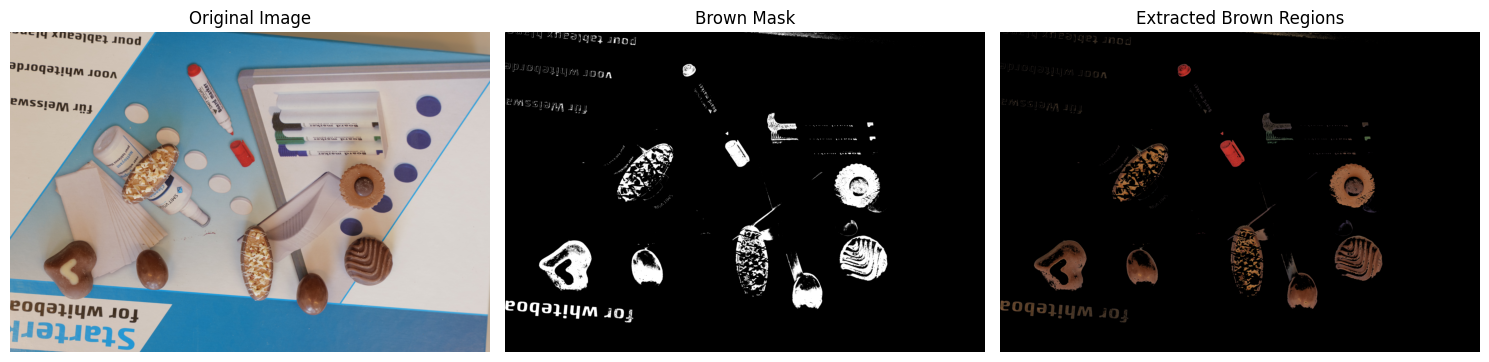

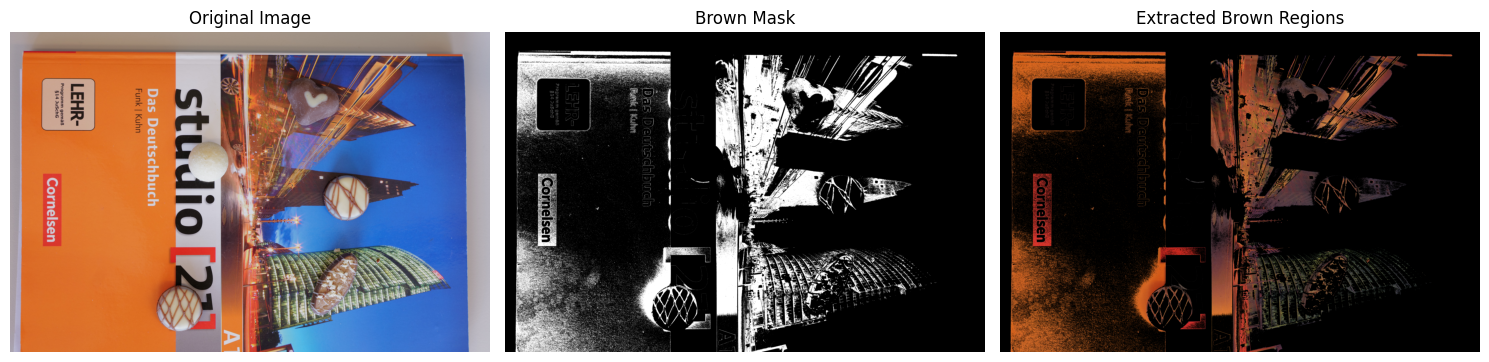

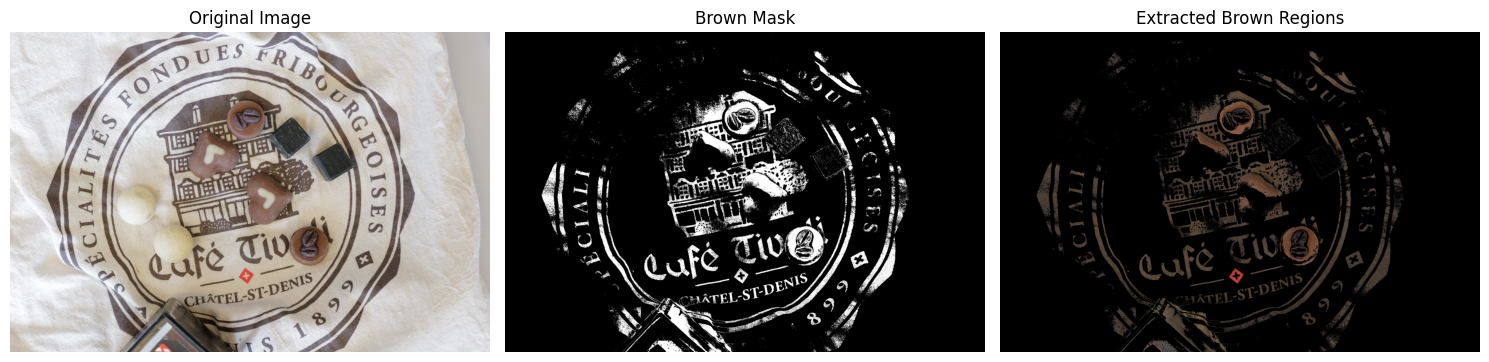

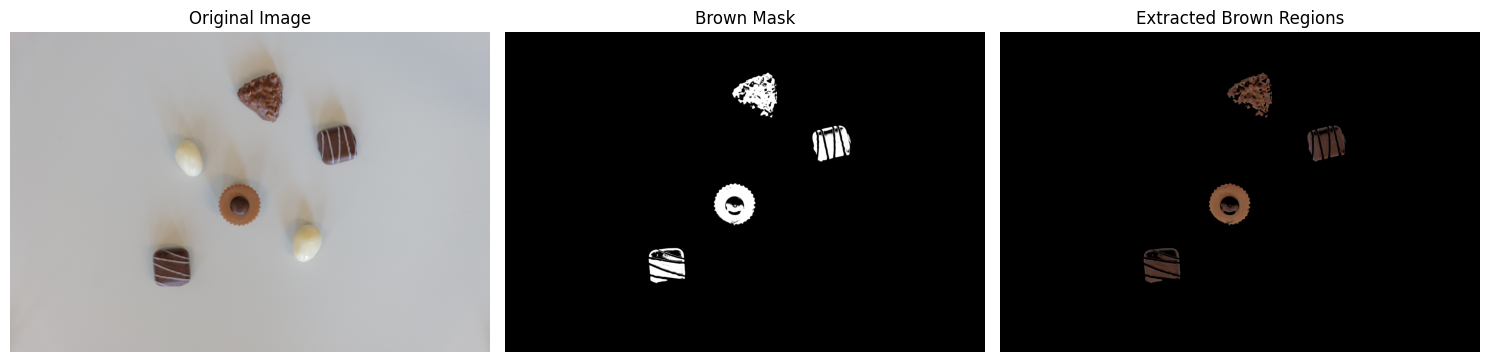

In [3]:
for img in loaded_images:
    # Define lower and upper bounds for brown in RGB
    lower_brown = np.array([60, 40, 0])    # R, G, B
    upper_brown = np.array([220, 140, 80])

    # Create mask
    mask = cv2.inRange(img, lower_brown, upper_brown)

    # Apply mask to original image
    brown_regions = cv2.bitwise_and(img, img, mask=mask)

    # Show results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Brown Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Extracted Brown Regions")
    plt.imshow(brown_regions)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
#TEST KMEANS TO CLASSIFY BACKGROUNDS

import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def get_average_hsv(image_path):
    """Compute average HSV color of an image."""
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    avg_hsv = np.mean(hsv_image, axis=(0, 1))
    return avg_hsv

def extract_features_from_folder(folder_path):
    """Extract average HSV from all images in a folder."""
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    features = []
    valid_paths = []
    for path in image_paths:
        try:
            avg_hsv = get_average_hsv(path)
            features.append(avg_hsv)
            valid_paths.append(path)
        except:
            print(f"Error reading {path}")
    return np.array(features), valid_paths


def cluster_images(features, n_clusters=6):
    """Run KMeans clustering on feature array."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels, kmeans.cluster_centers_

def show_cluster_examples(labels, image_paths, cluster_id):
    """Show example images from a specific cluster."""
    cluster_indices = np.where(labels == cluster_id)[0]
    #selected = cluster_indices[:max_images]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(cluster_indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(cluster_indices), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Images from Cluster {cluster_id}")
    plt.show()

# Set your image folder path
folder_path = '/Users/louiscuendet/Documents/EPFL NEURO-X /Image Analysis and Pattern Recognition/dataset_project_iapr2025/train'

# Extract features
features, image_paths = extract_features_from_folder(folder_path)

# Cluster the images
labels, centers = cluster_images(features, n_clusters=6)

# Initialize a list of lists to hold image paths per cluster
clustered_image_lists = [[] for _ in range(6)]  # 6 clusters

# Assign each image path to the appropriate cluster list
for path, label in zip(image_paths, labels):
    clustered_image_lists[label].append(path)


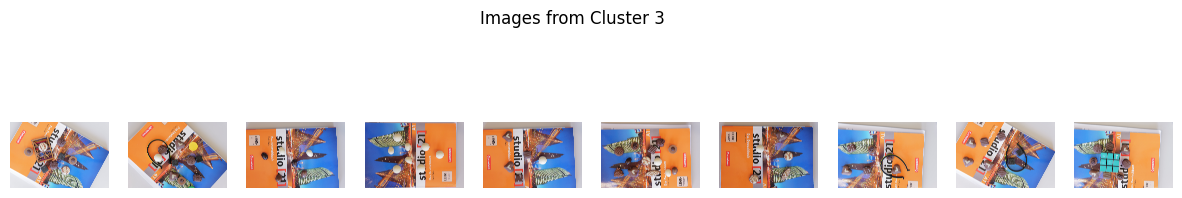

In [8]:
n = 2
plt.figure(figsize=(15, 3))
for i, path in enumerate(clustered_image_lists[n]):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(clustered_image_lists[n]), i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle(f"Images from Cluster 3")
plt.show()

In [6]:
def clean_image(img, min_area=2000):
    # 2. Convert to grayscale for processing
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 1.5)

    # 3. Threshold + Morphology to detect relevant areas
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4. Remove small or irregular objects (by contour shape and area)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= min_area:
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # 5. Apply the mask to the original color image
    cleaned = cv2.bitwise_and(img, img, mask=mask)

    # 5. Apply the mask to the original image (preserve color)
    cleaned = cv2.bitwise_and(img, img, mask=mask)

    return cleaned


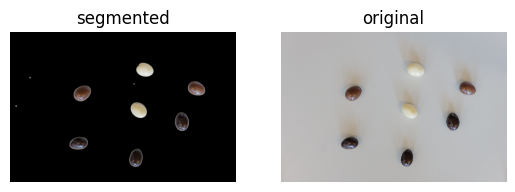

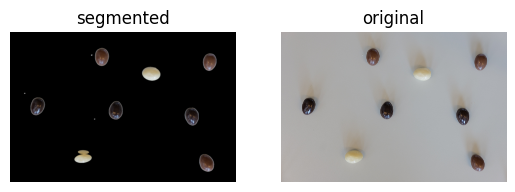

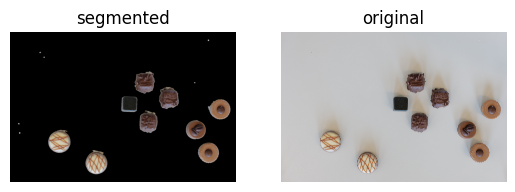

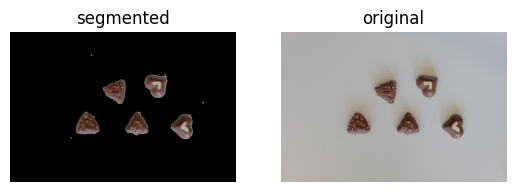

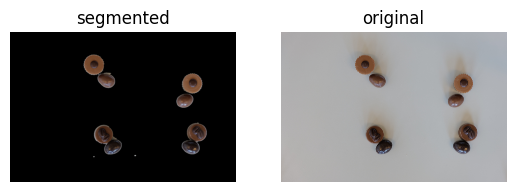

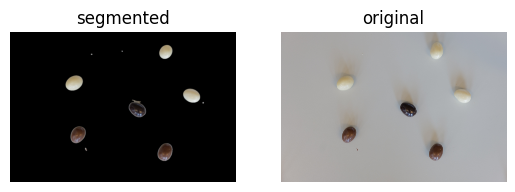

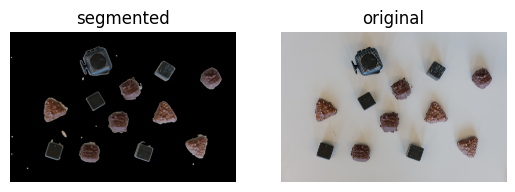

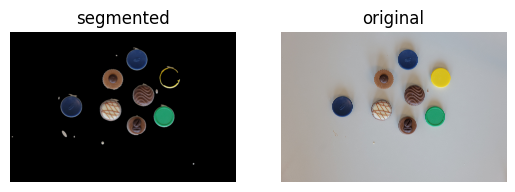

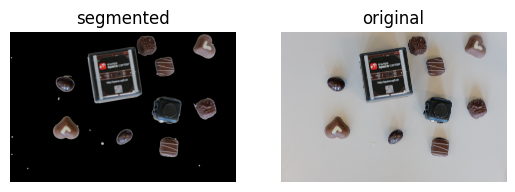

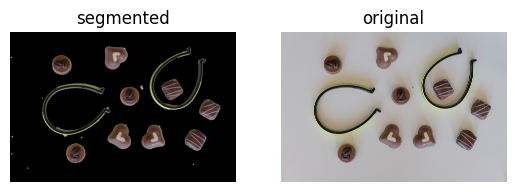

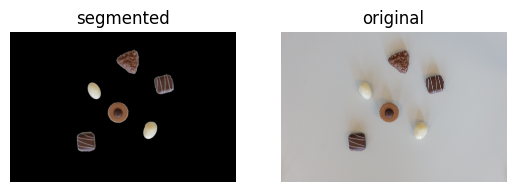

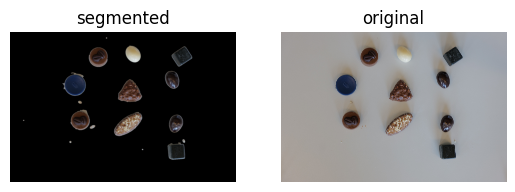

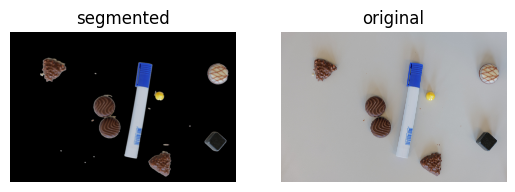

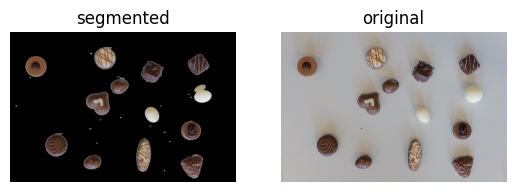

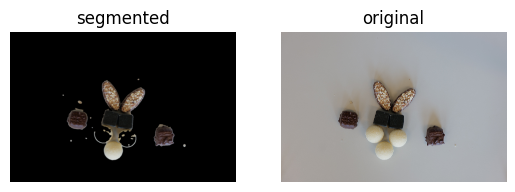

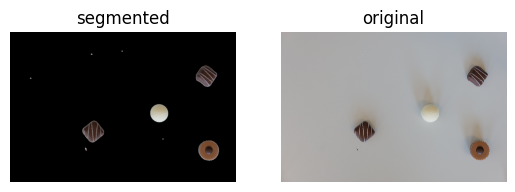

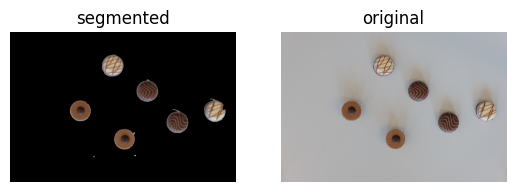

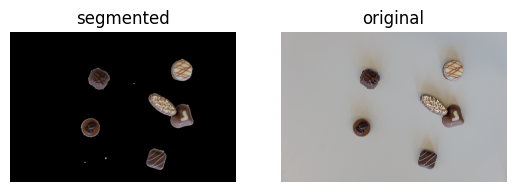

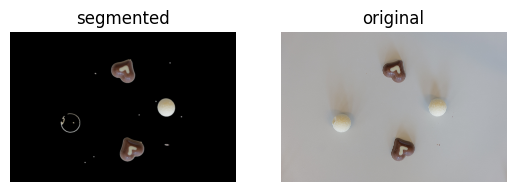

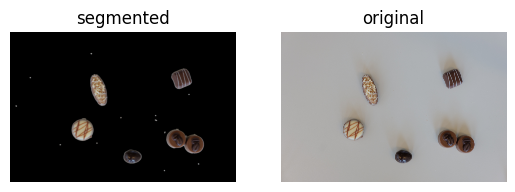

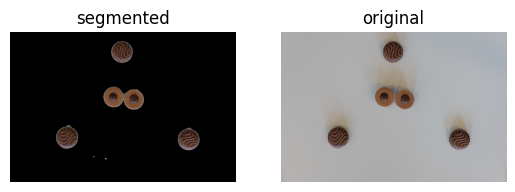

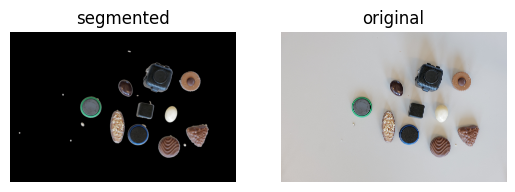

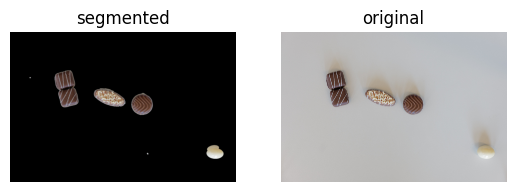

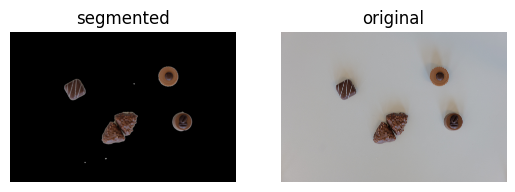

In [7]:
from segmentation_clean_background_functions import *

for path in clustered_image_lists[3]:
    img = mpimg.imread(path)
    res = segmentation(img)
    plot_choc(res,img)